In [ ]:
params = {
    # Global parameters
    "T_target": 334,
    "t_span": (1e-8, 1e1),
    "t0": 1e-3,
    "A_in": 24.8378,
    "MobileTS": True,
    "T_min": 400,
    "T_max": 900,

    # Molecule 6 (NO2, nonlinear)
    "molecule_molecule_type": "nonlinear",
    "molecule_p": 0.125,
    "molecule_m": 45.99290,
    "molecule_Edes": 1.4108,
    "molecule_sigma": 2.0,
    "molecule_theta_rot_A": 12.23047,
    "molecule_theta_rot_B": 0.63849,
    "molecule_theta_rot_C": 0.60681,

    ## Molecule 1 (O2, linear)
    #"molecule_molecule_type": "linear",
    #"molecule_p": 0.125,
    #"molecule_m": 31.98983,
    #"molecule_Edes": 0.5634,
    #"molecule_sigma": 2.0,
    #"molecule_theta_rot_linear": 2.14799,
}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Physical constants
kB = 1.380649e-23   # Boltzmann constant (J/K)
h = 6.62607015e-34   # Planck constant (J·s)

original_cmap = plt.get_cmap("YlGnBu_r")
new_cmap = colors.LinearSegmentedColormap.from_list(
    "new_cmap",
    original_cmap(np.linspace(0.15, 1, 256))
)

def compute_rate_constants_single(params, T):

    molecule_type = params["molecule_molecule_type"]
    p_bar   = params["molecule_p"]
    m_amu   = params["molecule_m"]
    Edes_eV = params["molecule_Edes"]
    sigma   = params["molecule_sigma"]

    p = p_bar * 1e5
    A = params["A_in"] * 1e-20
    m_kg = m_amu * 1.660539e-27
    Edes_J = Edes_eV * 1.602176565e-19

    mobile_ts = params.get("MobileTS")
    if isinstance(mobile_ts, str):
        mobile_ts = mobile_ts.strip().lower() == "true"

    if mobile_ts:
        k_ads = p * A / np.sqrt(2.0 * np.pi * m_kg * kB * T)
        k_des = (kB * T**2) / h**3 * (2.0 * A * np.pi * m_kg * kB) * np.exp(-Edes_J/(kB*T))
    else:
        if molecule_type == "linear":
            theta_rot = params["molecule_theta_rot_linear"]
            k_ads = p * A / np.sqrt(2.0 * np.pi * m_kg * kB * T) * (sigma * theta_rot / T)
            k_des = (kB * T**3) / h**3 * (2.0 * A * np.pi * m_kg * kB/(sigma * theta_rot)) * np.exp(-Edes_J/(kB*T))
        elif molecule_type == "nonlinear":
            theta_rot_A = params["molecule_theta_rot_A"]
            theta_rot_B = params["molecule_theta_rot_B"]
            theta_rot_C = params["molecule_theta_rot_C"]
            theta_rot_product = theta_rot_A * theta_rot_B * theta_rot_C
            k_ads = p * A / np.sqrt(2.0 * np.pi * m_kg * kB * T) * (sigma / np.sqrt(np.pi)) * np.sqrt(theta_rot_product/T**3)
            k_des = (kB * T**3.5) / h**3 * (2.0 * A * np.pi**1.5 * m_kg * kB/(sigma * np.sqrt(theta_rot_product))) * np.exp(-Edes_J/(kB*T))
        else:
            raise ValueError(f"Unknown molecule type: {molecule_type}")
    return k_ads, k_des

def c_a_curve(T, params, t_values):
    k_ads, k_des = compute_rate_constants_single(params, T)
    c_a0 = 1.0
    t0 = params["t0"]
    c_a_t0 = (k_ads/(k_ads+k_des)) * (1 - np.exp(-(k_ads+k_des)*t0)) * c_a0
    c_a_vals = np.where(t_values <= t0,
                        (k_ads/(k_ads+k_des)) * (1 - np.exp(-(k_ads+k_des)*t_values)) * c_a0,
                        c_a_t0 * np.exp(-k_des*(t_values - t0))
                       )
    return c_a_vals

def compute_cA_star_T(params):
    import numpy as np

    t_min, t_max = params["t_span"]
    t_eval = np.logspace(np.log10(t_min), np.log10(t_max), 200)

    T_min = params["T_min"]
    T_max = params["T_max"]
    T_eval = np.linspace(T_min, T_max, 50)

    cA_star_T = np.zeros((len(T_eval), len(t_eval)))

    for i, T in enumerate(T_eval):
        cA_star_T[i, :] = c_a_curve(T, params, t_eval)

    return t_eval, T_eval, cA_star_T

def plot_3d_c_a_custom(params):

    t_eval, T_eval, cA_star_T = compute_cA_star_T(params)
    T_grid, t_grid = np.meshgrid(T_eval, t_eval, indexing="ij")

    vmin = 0
    vmax = 1

    fig, axes = plt.subplots(1, 2, figsize=(20, 12), subplot_kw={'projection': '3d'}, constrained_layout=False)
    ax1, ax2 = axes

    surf1 = ax1.plot_surface(
        np.log10(t_grid),
        T_grid,
        cA_star_T,
        cmap=new_cmap,
        edgecolor=(0.2, 0.2, 0.2, 0.2),
        vmin=vmin,
        vmax=vmax
    )
    ax1.set_xlabel('t (s)', fontsize=18, labelpad=15)
    ax1.set_ylabel('T (K)', fontsize=18, labelpad=15)
    ax1.set_zlabel(r'$\theta_{A^*}$', fontsize=18, labelpad=15)
    ax1.set_xlim([np.log10(np.min(t_eval)), np.log10(np.max(t_eval))])
    ax1.set_ylim([np.min(T_eval), np.max(T_eval)])
    ax1.set_zlim([np.min(cA_star_T), np.max(cA_star_T)])
    ax1.tick_params(axis='x', labelsize=12, pad=6)
    ax1.tick_params(axis='y', labelsize=12, pad=6)
    ax1.tick_params(axis='z', labelsize=12, pad=6)
    ax1.view_init(elev=30, azim=105)
    ax1.set_box_aspect([1.5, 1.5, 1])

    surf2 = ax2.plot_surface(
        np.log10(t_grid),
        T_grid,
        cA_star_T,
        cmap=new_cmap,
        edgecolor=(0.2, 0.2, 0.2, 0.2),
        vmin=vmin,
        vmax=vmax
    )
    ax2.set_xlabel('t (s)', fontsize=18, labelpad=15)
    ax2.set_ylabel('T (K)', fontsize=18, labelpad=15)
    ax2.set_zlabel(r'$\theta_{A^*}$', fontsize=18, labelpad=15)
    ax2.set_xlim([np.log10(np.min(t_eval)), np.log10(np.max(t_eval))])
    ax2.set_ylim([np.min(T_eval), np.max(T_eval)])
    ax2.set_zlim([np.min(cA_star_T), np.max(cA_star_T)])
    ax2.tick_params(axis='x', labelsize=12, pad=6)
    ax2.tick_params(axis='y', labelsize=12, pad=6)
    ax2.tick_params(axis='z', labelsize=12, pad=6)
    ax2.view_init(elev=60, azim=45)
    ax2.set_box_aspect([1.5, 1.5, 1])

    for ax in (ax1, ax2):
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"$10^{{{int(x)}}}$"))
        x_tick_min = int(np.floor(np.log10(np.min(t_eval))))
        x_tick_max = int(np.ceil(np.log10(np.max(t_eval)))) + 1
        ax.xaxis.set_ticks([float(xx) for xx in range(x_tick_min, x_tick_max)])


    cbar = fig.colorbar(surf1, ax=[ax1, ax2], fraction=0.02, pad=0.07)
    cbar.set_label("Coverage", fontsize=18, labelpad=15)
    cbar.ax.tick_params(labelsize=14)

    plt.subplots_adjust(right=0.85, wspace=0.2)
    plt.savefig("Coverage_time_Temp.png", dpi=600)
    plt.show()

<ipython-input-2-cb0847ccbf04>:61: RuntimeWarning: overflow encountered in exp
  c_a_t0 * np.exp(-k_des*(t_values - t0))


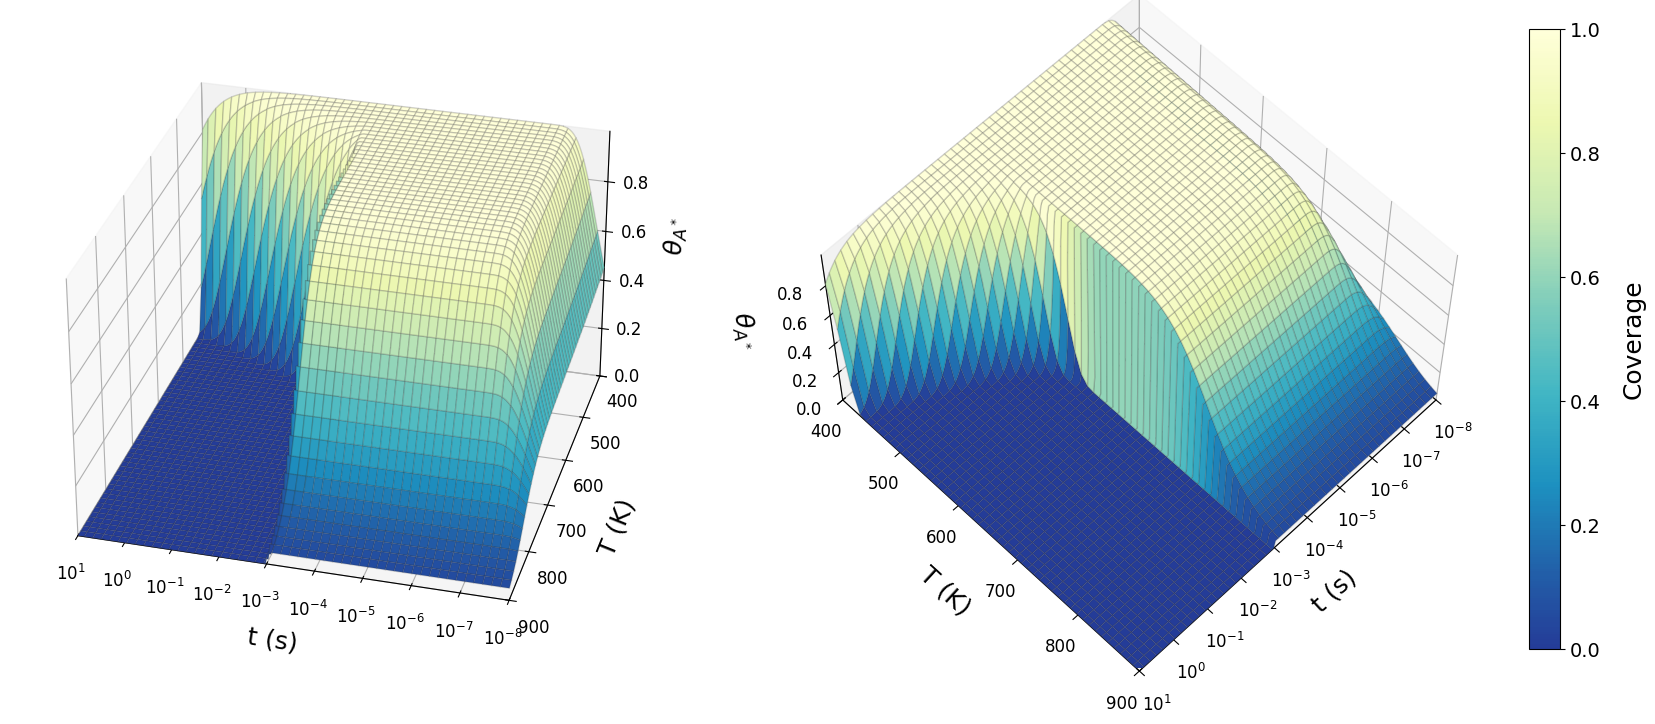

In [ ]:
plot_3d_c_a_custom(params)